# PreFab v1.1.0

[PreFab v1.1.0](https://github.com/PreFab-Photonics/PreFab) is now available! Install it via [PyPI](https://pypi.org/project/prefab/) with the following command:

```bash
pip install --upgrade prefab
```

**PreFab is a Python library designed to predict and correct nanofabrication variations in integrated photonic devices using advanced computer vision models.** It helps enhance fabrication awareness and boosts efficiency in the design, fabrication, and testing of photonic circuits.

## What's new with us

PreFab is a new startup originating from [McGill University](https://www.mcgill.ca/) in Montreal, Canada. As we continue to grow, we are eager to learn about your needs and how we can enhance our platform. Our team is small, so we appreciate your patience as we work on these improvements. Reach out to us at [hi@prefabphotonics.com](mailto:hi@prefabphotonics.com) to work together.

- **We have launched a new LinkedIn page** [here](https://www.linkedin.com/company/prefab-photonics/) where we will announce new features and updates. Follow us to stay informed.

- **We've updated our logo** to be less busy while retaining its original charm and essence. We hope you like the new design!

![New PreFab Logo](https://github.com/PreFab-Photonics/PreFab/blob/main/docs/assets/logo.png?raw=true)


## Features

This release brings a host of new features and enhancements to elevate your experience with PreFab. While our core functionality of predicting and correcting nanofabrication variations remains unchanged, we've added several valuable tools for working with nanostructure geometries.

### Shapes!

While `read.from_gds` is used to import your GDS cells, the new `shapes` module allows you to create basic nanostructure devices directly. This feature is not only beneficial for our internal testing but also provides a convenient way for you to test PreFab models on simple geometries. Below are some examples.

<Axes: xlabel='x (nm)', ylabel='y (nm)'>

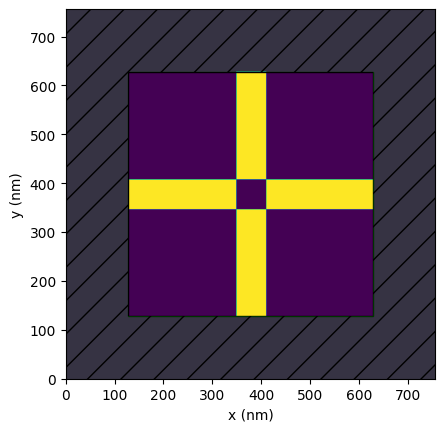

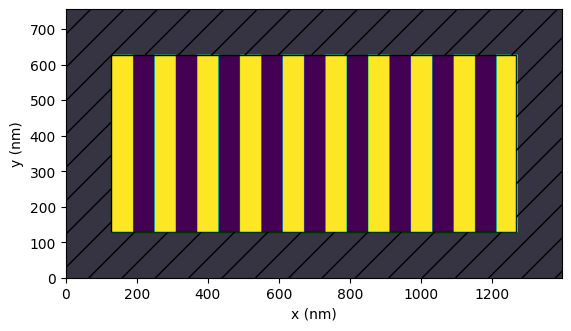

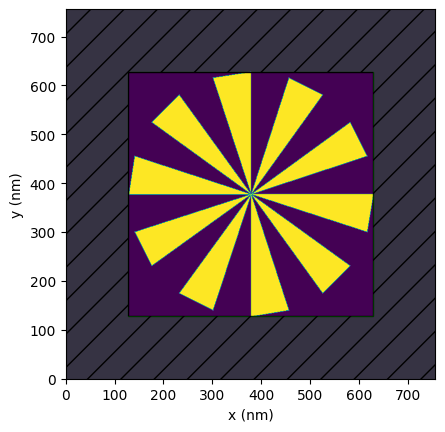

In [1]:
import prefab as pf

target = pf.shapes.target(width=500, arm_width=60)
target.plot()

grating = pf.shapes.grating(height=500, pitch=120, duty_cycle=0.5, num_gratings=10)
grating.plot()

radial_grating = pf.shapes.radial_grating(width=500, num_gratings=10)
radial_grating.plot()

### GPU acceleration

We've introduced GPU acceleration to the backend of PreFab by specifying `gpu=True` in `Device.predict` and `Device.correct`. This enhancement should speed up predictions for larger devices. As PreFab is a free service, CPU inference remains the default to keep the service readily available ("hot") for users. For now, the GPU will be in a "cold" state, requiring additional time to start up. Consequently, the first GPU prediction will be slower due to this overhead. We kindly ask that you use the GPU feature modestly (scouts' honor).


In [2]:
import time

import prefab as pf

grating = pf.shapes.grating(height=500, pitch=120, duty_cycle=0.5, num_gratings=200)

# Timing the CPU correction
start_time = time.time()
grating_c_cpu = grating.correct(model=pf.models["ANT_NanoSOI_ANF1_d10"], gpu=False)
cpu_duration = time.time() - start_time
print(f"CPU correction time: {cpu_duration:.2f} seconds")

# Timing the first GPU correction (cold start)
start_time = time.time()
grating_c_gpu = grating.correct(model=pf.models["ANT_NanoSOI_ANF1_d10"], gpu=True)
gpu_duration = time.time() - start_time
print(f"Cold GPU correction time: {gpu_duration:.2f} seconds")

# Timing the second GPU correction (hot start)
start_time = time.time()
grating_c_gpu2 = grating.correct(model=pf.models["ANT_NanoSOI_ANF1_d10"], gpu=True)
gpu_duration2 = time.time() - start_time
print(f"Hot GPU correction time: {gpu_duration2:.2f} seconds")

Correction: 100%|██████████████████████████████| 100/100 [00:17<00:00,  5.75%/s]


CPU correction time: 17.68 seconds


Correction: 100%|██████████████████████████████| 100/100 [00:08<00:00, 12.39%/s]


Cold GPU correction time: 27.42 seconds


Correction: 100%|██████████████████████████████| 100/100 [00:02<00:00, 44.18%/s]

Hot GPU correction time: 2.47 seconds


### Minimum feature size

We've added tools to check and enforce minimum feature sizes of devices you are working with. The `Device.check_feature_size` and `Device.enforce_feature_size` methods help ensure your designs meet sizing requirements. While these tools are not full design rule checking (DRC) solutions, we believe they can be useful early in the design process.

Feature size check with minimum size 30 using 'disk' structuring element resulted in a Hamming distance of: 702


<Axes: xlabel='x (nm)', ylabel='y (nm)'>

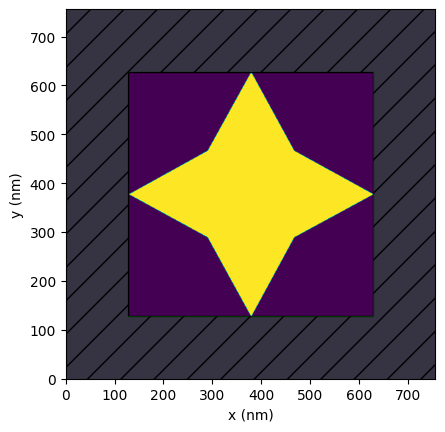

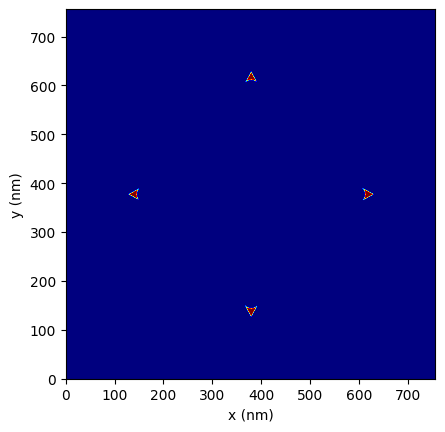

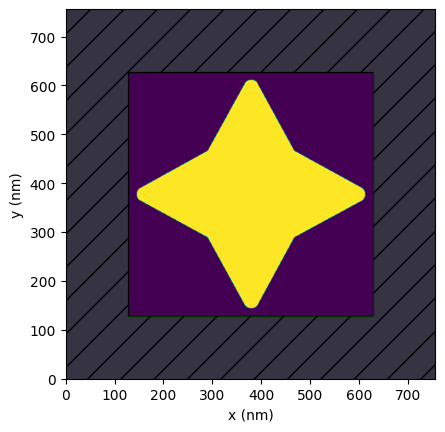

In [11]:
import prefab as pf

star = pf.shapes.star(width=500, num_points=4)
star.plot()

star.check_feature_size(min_feature_size=30, strel="disk")
star_e = star.enforce_feature_size(min_feature_size=30, strel="disk")
star_e.plot()

### 3D structures

We have introduced the `Device.to_3d` and `Device.to_stl` methods to convert your 2D device structures into 3D arrays or STL files. These features are particularly useful for simulating processes with angled sidewalls. For more details on working with angled sidewalls, refer to this [notebook](../examples/3_sidewall_angle.ipynb).

The `Device.plot` method displays the upper and lower edges of the sidewall-angled device structure. These two new methods use the edges as boundaries for the 3D extrusion.

Prediction: 100%|██████████████████████████████| 100/100 [00:04<00:00, 22.84%/s]


Saved Device to 'prefab_device.stl'


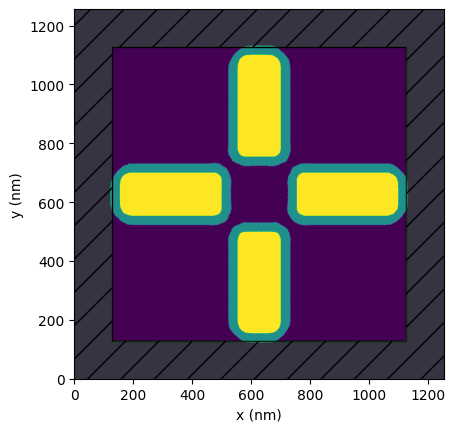

In [1]:
import prefab as pf

target = pf.shapes.target(width=1000, arm_width=200)
target_p = target.predict(model=pf.models["ANT_SiN_ANF1_d1"], binarize=True)
target_p.plot()

target_p_3d = target_p.to_3d(thickness_nm=400)  # visualizer to come soon
target_p.to_stl(thickness_nm=400)  # this will create a 3D STL file you can inspect

### 3rd-party libraries

PreFab should seamlessly fit into your existing design flow. As such, we're adding tools to read and write from/to common libraries such as [Tidy3D](https://www.flexcompute.com/tidy3d/) and [gdsfactory](https://gdsfactory.github.io/gdsfactory/).

This first example shows how to read a gdsfactory component, correct it using PreFab, and then convert it back to a gdsfactory component.


Correction: 100%|██████████████████████████████| 100/100 [00:02<00:00, 46.44%/s]


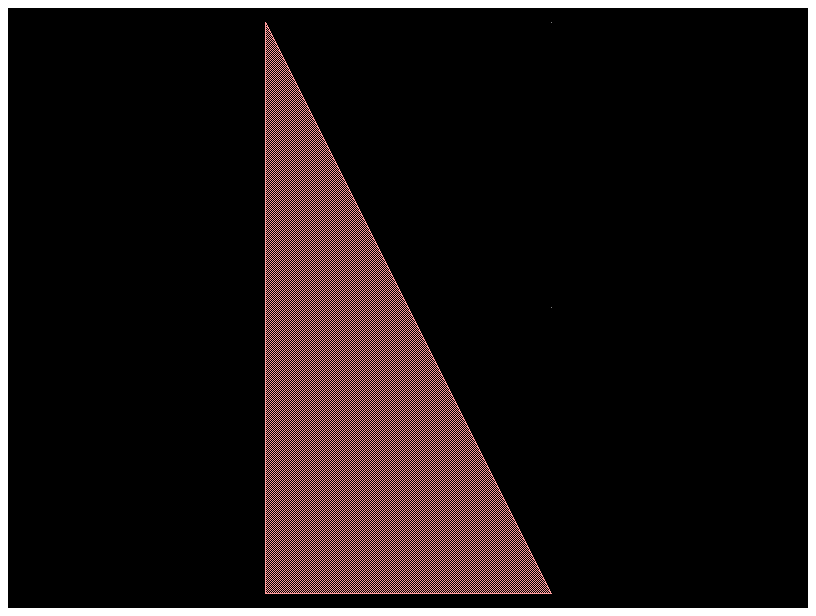

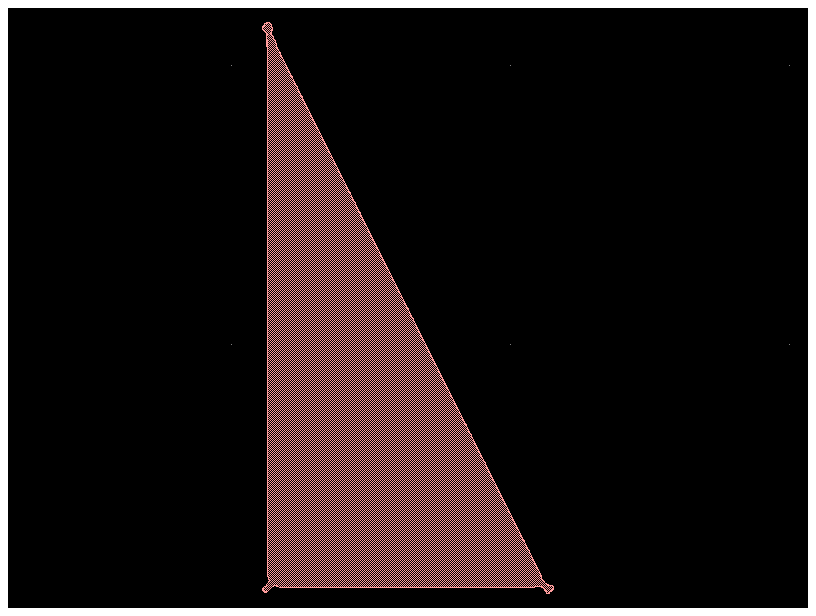

In [16]:
import gdsfactory as gf
import prefab as pf

component = gf.components.triangle(x=1, xtop=0, y=2, ybot=0, layer="WG")
component.plot()
device = pf.read.from_gdsfactory(component)

device_c = device.correct(model=pf.models["ANT_NanoSOI_ANF1_d10"], binarize=True)
component_c = device_c.to_gdsfactory()
component_c.plot()

This second example shows how to read a Tidy3D simulation, correct the structure using PreFab, and then send it back to a Tidy3D simulation.

Prediction: 100%|██████████████████████████████| 100/100 [00:10<00:00,  9.26%/s]


<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

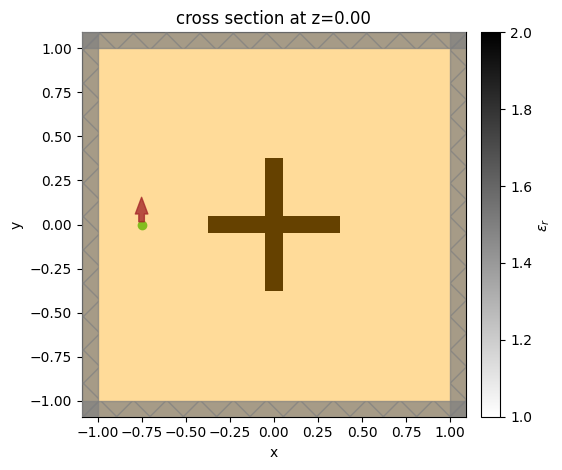

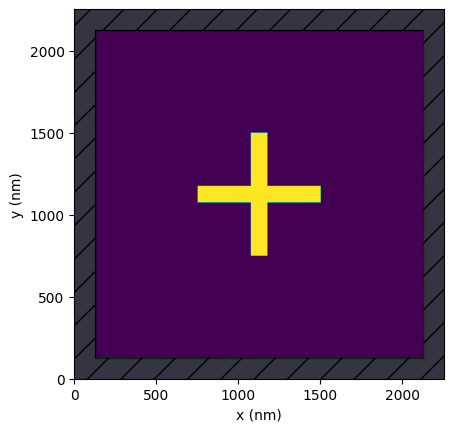

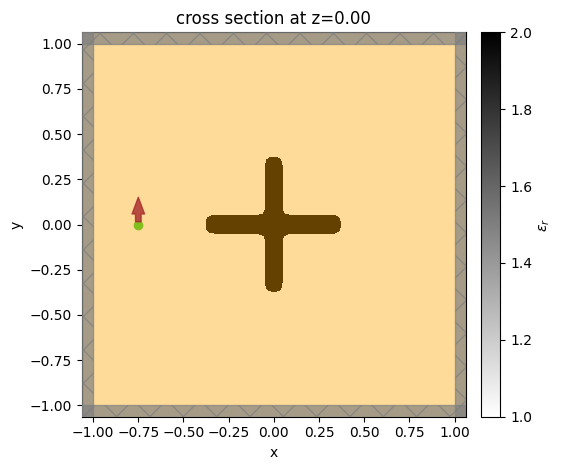

In [20]:
import prefab as pf
import tidy3d as td

freq0 = td.C_0 / 0.75
arm1 = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(0.1, 0.75, 0.22)),
    medium=td.Medium(permittivity=2.0),
)
arm2 = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(0.75, 0.1, 0.22)),
    medium=td.Medium(permittivity=2.0),
)
source = td.PointDipole(
    center=(-0.75, 0, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10.0),
    polarization="Ey",
)
monitor = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="fields",
    colocate=True,
)
sim = td.Simulation(
    size=(2, 2, 3),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=100),
    structures=[arm1, arm2],
    sources=[source],
    monitors=[monitor],
    run_time=120 / freq0,
)

sim.plot_eps(z=0)

device = pf.read.from_tidy3d(tidy3d_sim=sim, eps_threshold=1.5, z=0)
device.plot()

device_p = device.predict(model=pf.models["ANT_NanoSOI_ANF1_d10"], binarize=True)
structure_p = device_p.to_tidy3d(eps0=2.0, thickness=1.5)

sim_p = sim.updated_copy(structures=[structure_p])
sim_p.plot_eps(z=0)

## What's next

We're excited about the future of PreFab and how we can help you gain more control over your nanofabrication process. Here are our key focus areas for the upcoming months:

- **Performance Enhancements**: We are implementing several improvements to accelerate predictions, particularly for larger devices.
- **Expanding Model Library**: We are adding more models to our platform. If you have a specific nanofabrication process in mind, please reach out to us!
- **Innovative Usage Methods**: We have exciting ideas to make PreFab even more powerful, particularly within the design optimization process. Look out for more updates on this front.
- **Code Quality**: We are working on improving the code quality of PreFab to make it more robust and easier to maintain. This will lay the foundation for future development and collaboration.
- **Community Engagement**: We value your input and are eager to hear your ideas and suggestions. Please reach out to us at [support@prefabphotonics.com](mailto:hi@prefabphotonics.com) with your feedback.

Thank you for your support, and happy designing!